In [66]:
from pennylane import PauliX
from qiskit import QuantumCircuit, ClassicalRegister, transpile
from qiskit.visualization import plot_histogram
import numpy as np
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
import secrets

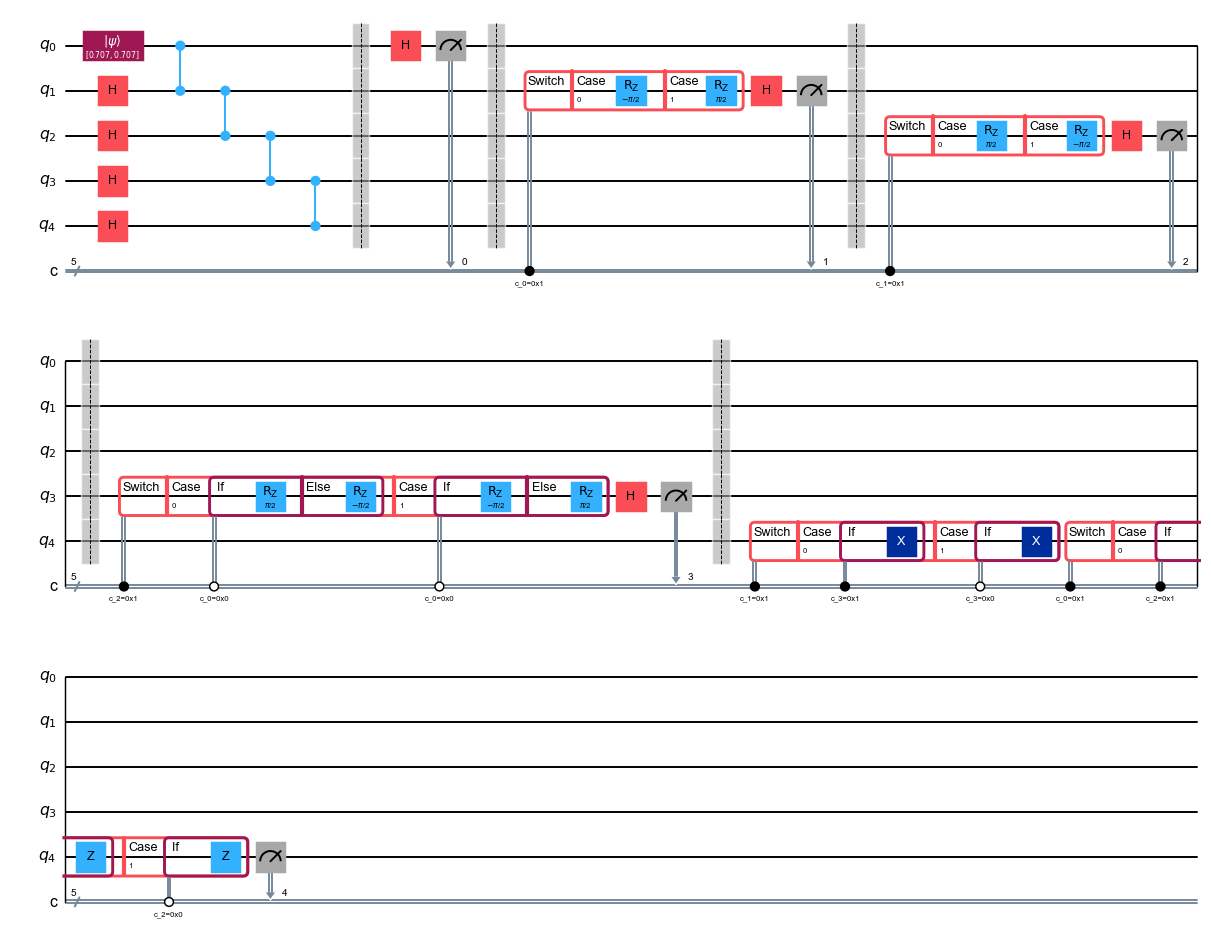

In [3]:
# universal one qubit gate using measurement-based quantum computation
qc = QuantumCircuit(5,5)
(q0, q1, q2, q3, q4) = qc.qubits
(c0, c1, c2, c3, c4) = qc.clbits

theta0 = np.pi/2
theta1 = np.pi/2
theta2 = np.pi/2

# initiaze qubit 0
vector = [1, 1]
# normalize the vector
vector = vector / np.linalg.norm(vector)
qc.initialize(vector, q0)

for i in range(1,5):
    qc.h(i)

qc.cz(q0, q1)
qc.cz(q1, q2)
qc.cz(q2, q3)
qc.cz(q3, q4)
qc.barrier()

qc.h(q0)
qc.measure(q0, c0)
qc.barrier()


with qc.switch(c0) as case:
    with case(0):
        qc.rz(-theta0, q1)
    with case(1):
        qc.rz(theta0, q1)
qc.h(1)
qc.measure(q1, c1)


qc.barrier()

with qc.switch(c1) as case:
    with case(0):
        qc.rz(theta1, q2)
    with case(1):
        qc.rz(-theta1, q2)

qc.h(2)
qc.measure(q2, c2)
qc.barrier()

with qc.switch(c2) as case:
    with case(0):
        with qc.if_test((c0, 0)) as else_:
            qc.rz(theta2, q3)
        with else_:
            qc.rz(-theta2, q3)
    with case(1):
        with qc.if_test((c0, 0)) as else_:
            qc.rz(-theta2, q3)
        with else_:
            qc.rz(theta2, q3)


qc.h(3)
qc.measure(q3, c3)
qc.barrier()



# if c0 xor c2 == 1, then apply X gate to q3
with qc.switch(c1) as case:
    with case(0):
        with qc.if_test((c3, 1)):
            qc.x(q4)
    with case(1):
        with qc.if_test((c3, 0)):
            qc.x(q4)

# if c1 == 1, then apply Z gate to q3
with qc.switch(c0) as case:
    with case(0):
        with qc.if_test((c2, 1)):
            qc.z(q4)
    with case(1):
        with qc.if_test((c2, 0)):
            qc.z(q4)

qc.measure(q4, c4)



qc.draw('mpl', scale=0.7)


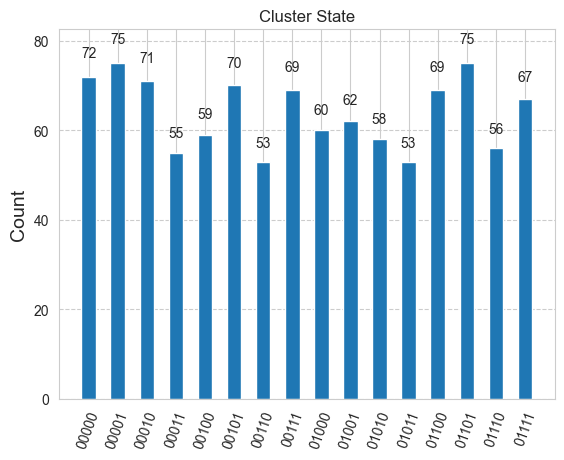

In [4]:
# Simulation of universal one qubit gate using measurement-based quantum computation
simulator = AerSimulator()
circ = transpile(qc, simulator)
# Run and get counts
result = simulator.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Cluster State')

Counts for qubit 4:
{'0': 1024, '1': 0}


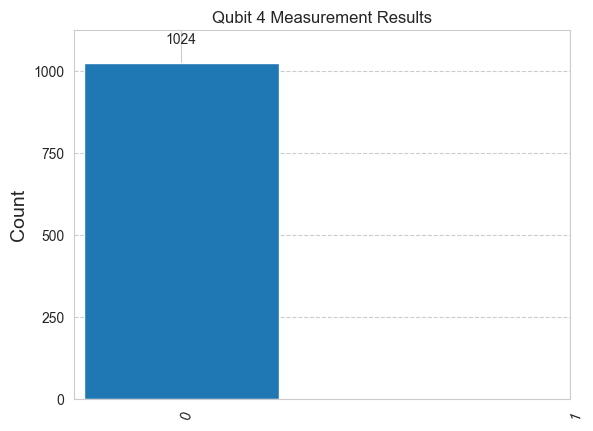

In [5]:
# Results for output qubit 4
# Extract the counts for the first qubit (qubit 4)
qubit_4_counts = {"0": 0, "1": 0}  # Initialize counts for qubit 4

for key, value in counts.items():
    first_bit = key[0]  # Get the first bit (qubit 4's result)
    qubit_4_counts[first_bit] += value

# Print the results
print("Counts for qubit 4:")
print(qubit_4_counts)

# Optionally, plot the results for qubit 4
plot_histogram(qubit_4_counts, title="Qubit 4 Measurement Results")


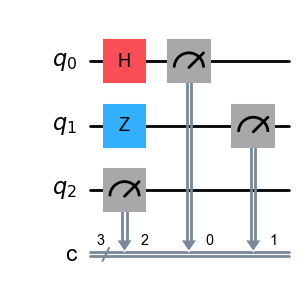

In [67]:
# We need to reverse the order of the bits in the key to match the qubit order
# The example below shows why this is necessary
qc = QuantumCircuit(3,3)
(q0, q1, q2) = qc.qubits
(c0, c1, c2) = qc.clbits

qc.h(q0)
qc.z(q1)

qc.measure(q0, c0)
qc.measure(q1, c1)
qc.measure(q2, c2)
qc.draw('mpl')


In [68]:
# Simulation
simulator = AerSimulator()
results = []
results = simulator.run(qc, shots=1000).result()
results.get_counts()

# We can see that the results are not as expected
# But if we reverse the order of the bits in the key, we get the expected results

{'001': 531, '000': 469}

In [4]:
# Brickwork State Circuit Class
class BrickworkStateCircuit:
    def __init__(self, k_values, r_values, phi=None):
        self.k_values = k_values
        self.r_values = r_values
        self.theta = [k * np.pi / 4 for k in k_values]
        self.phi = phi if phi is not None else [
            np.pi/2, np.pi/2, np.pi/2, 0, 0,  # first row
            np.pi/2, np.pi/2, np.pi/2, 0, 0   # second row
        ]
        # delta values which are sent from the client to the server
        # delta = phi - theta
        self.delta = self.theta.copy()
        self.qc = QuantumCircuit(10, 10)
        (q0, q1, q2, q3, q4, q5, q6, q7, q8, q9) = self.qc.qubits
        (c0, c1, c2, c3, c4, c5, c6, c7, c8, c9) = self.qc.clbits
        self.q = self.qc.qubits
        self.c = self.qc.clbits
        self.build_circuit()

    # Build the brickwork state circuit
    def build_circuit(self):
        self.apply_hadamard_gates()
        self.apply_rz_gates()
        self.apply_cz_gates()
        self.qc.barrier()
        self.operation_on_0th_qubit()
        self.operation_on_5th_qubit()
        self.qc.barrier()
        self.operation_on_1st_qubit()
        self.operation_on_6th_qubit()
        self.qc.barrier()
        self.operation_on_2nd_qubit()
        self.operation_on_7th_qubit()
        self.qc.barrier()
        self.operation_on_3rd_qubit()
        self.operation_on_8th_qubit()
        self.qc.barrier()
        self.operation_on_4th_qubit()
        self.operation_on_9th_qubit()
        return self.qc

    # Draw the circuit
    def draw_circuit(self):
        return self.qc.draw('mpl')

    # Apply Hadamard gates to all qubits
    def apply_hadamard_gates(self):
        for i in range(10):
            self.qc.h(i)

    # Apply RZ gates with theta values
    def apply_rz_gates(self):
        for i in range(10):
            self.qc.rz(self.theta[i], i)

    # Apply CZ gates between adjacent qubits
    def apply_cz_gates(self):
        self.qc.cz(0, 1)
        self.qc.cz(1, 2)
        self.qc.cz(2, 3)
        self.qc.cz(3, 4)
        self.qc.cz(5, 6)
        self.qc.cz(6, 7)
        self.qc.cz(7, 8)
        self.qc.cz(8, 9)

    # Operation on 0th qubit
    def operation_on_0th_qubit(self):
        delta0 = self.phi[0] - self.theta[0] + self.r_values[0]*np.pi
        self.qc.rz(delta0, self.q[0])
        self.qc.h(self.q[0])
        self.qc.measure(0, self.c[0])

    # Operation on 5th qubit
    def operation_on_5th_qubit(self):
        delta5 = self.phi[5] - self.theta[5] + self.r_values[5]*np.pi
        self.qc.rz(delta5, self.q[5])
        self.qc.h(self.q[5])
        self.qc.measure(5, self.c[5])


    # Operation on 1st qubit
    def operation_on_1st_qubit(self):
        if self.r_values[0] == 0:
            with self.qc.switch(self.c[0]) as case:
                with case(0):
                    self.delta[1] = self.phi[1] - self.theta[1] + self.r_values[1] * np.pi
                    self.qc.rz(self.delta[1], self.q[1])
                with case(1):
                    self.phi[1] = -self.phi[1]  # Apply RZ(-phi1) if c0 = 1
                    self.delta[1] = self.phi[1] - self.theta[1] + self.r_values[1] * np.pi
                    self.qc.rz(self.delta[1], self.q[1])
        else:
            with self.qc.switch(self.c[0]) as case:
                with case(1):
                    self.delta[1] = self.phi[1] - self.theta[1] + self.r_values[1] * np.pi
                    self.qc.rz(self.delta[1], self.q[1])
                with case(0):
                    self.phi[1] = -self.phi[1]  # Apply RZ(-phi1) if c0 = 0
                    self.delta[1] = self.phi[1] - self.theta[1] + self.r_values[1] * np.pi
                    self.qc.rz(self.delta[1], self.q[1])
        self.qc.h(self.q[1])
        self.qc.measure(self.q[1], self.c[1])

    # Operation on 6th qubit
    def operation_on_6th_qubit(self):
        if self.r_values[5] == 0:
            with self.qc.switch(self.c[5]) as case:
                with case(0):
                    self.delta[6] = self.phi[6] - self.theta[6] + self.r_values[6] * np.pi
                    self.qc.rz(self.delta[6], self.q[6])
                with case(1):
                    self.phi[6] = -self.phi[6]  # Apply RZ(-phi6) if c5 = 1
                    self.delta[6] = self.phi[6] - self.theta[6] + self.r_values[6] * np.pi
                    self.qc.rz(self.delta[6], self.q[6])
        else:
            with self.qc.switch(self.c[5]) as case:
                with case(1):
                    self.delta[6] = self.phi[6] - self.theta[6] + self.r_values[6] * np.pi
                    self.qc.rz(self.delta[6], self.q[6])
                with case(0):
                    self.phi[6] = -self.phi[6]  # Apply RZ(-phi6) if c5 = 0
                    self.delta[6] = self.phi[6] - self.theta[6] + self.r_values[6] * np.pi
                    self.qc.rz(self.delta[6], self.q[6])
        self.qc.h(self.q[6])
        self.qc.measure(self.q[6], self.c[6])

    # Operation on 2nd qubit
    def operation_on_2nd_qubit(self):
        if self.r_values[1] == 0:
            with self.qc.switch(self.c[1]) as case:
                with case(0):
                    self.delta[2] = self.phi[2] - self.theta[2] + self.r_values[2] * np.pi
                    self.qc.rz(self.delta[2], self.q[2])
                with case(1):
                    self.phi[2] = -self.phi[2]  # Apply RZ(-phi2) if c1 = 1
                    self.delta[2] = self.phi[2] - self.theta[2] + self.r_values[2] * np.pi
                    self.qc.rz(self.delta[2], self.q[2])
        else:
            with self.qc.switch(self.c[1]) as case:
                with case(1):
                    self.delta[2] = self.phi[2] - self.theta[2] + self.r_values[2] * np.pi
                    self.qc.rz(self.delta[2], self.q[2])
                with case(0):
                    self.phi[2] = -self.phi[2]  # Apply RZ(-phi2) if c1 = 0
                    self.delta[2] = self.phi[2] - self.theta[2] + self.r_values[2] * np.pi
                    self.qc.rz(self.delta[2], self.q[2])
        self.qc.h(self.q[2])
        self.qc.measure(self.q[2], self.c[2])

    # Operation on 7th qubit
    def operation_on_7th_qubit(self):
        if self.r_values[6] == 0:
            with self.qc.switch(self.c[6]) as case:
                with case(0):
                    self.delta[7] = self.phi[7] - self.theta[7] + self.r_values[7] * np.pi
                    self.qc.rz(self.delta[7], self.q[7])
                with case(1):
                    self.phi[7] = -self.phi[7]  # Apply RZ(-phi7) if c6 = 1
                    self.delta[7] = self.phi[7] - self.theta[7] + self.r_values[7] * np.pi
                    self.qc.rz(self.delta[7], self.q[7])
        else:
            with self.qc.switch(self.c[6]) as case:
                with case(1):
                    self.delta[7] = self.phi[7] - self.theta[7] + self.r_values[7] * np.pi
                    self.qc.rz(self.delta[7], self.q[7])
                with case(0):
                    self.phi[7] = -self.phi[7]  # Apply RZ(-phi7) if c6 = 0
                    self.delta[7] = self.phi[7] - self.theta[7] + self.r_values[7] * np.pi
                    self.qc.rz(self.delta[7], self.q[7])
        self.qc.h(self.q[7])
        self.qc.measure(self.q[7], self.c[7])

    # Operation on 3rd qubit
    def operation_on_3rd_qubit(self):
        if self.r_values[2] == 0:
            with self.qc.switch(self.c[6]) as case_c6:
                with case_c6(0):
                    with self.qc.switch(self.c[0]) as case_c0:
                        with case_c0(0):
                            with self.qc.switch(self.c[2]) as case_c2:
                                with case_c2(0):  # Apply RZ(-phi3) if c6 = 0, c0 = 0, c2 = 0
                                    self.delta[3] = self.phi[3] - self.theta[3] + self.r_values[3] * np.pi
                                    self.qc.rz(self.delta[3], self.q[3])
                                with case_c2(1):
                                    self.phi[3] = -self.phi[3]  # Apply RZ(-phi3) if c6 = 0, c0 = 0, c2 = 1
                                    self.delta[3] = self.phi[3] - self.theta[3] + self.r_values[3] * np.pi
                                    self.qc.rz(self.delta[3], self.q[3])
                        with case_c0(1):
                            with self.qc.switch(self.c[2]) as case_c2:
                                with case_c2(0):
                                    self.phi[3] = -self.phi[3]  # Apply RZ(-phi3) if c6 = 0, c0 = 1, c2 = 0
                                    self.delta[3] = self.phi[3] - self.theta[3] + self.r_values[3] * np.pi
                                    self.qc.rz(self.delta[3], self.q[3])
                                with case_c2(1):
                                    self.delta[3] = self.phi[3] - self.theta[3] + self.r_values[3] * np.pi
                                    self.qc.rz(self.delta[3], self.q[3])
                with case_c6(1):
                    with self.qc.switch(self.c[0]) as case_c0:
                        with case_c0(0):
                            with self.qc.switch(self.c[2]) as case_c2:
                                with case_c2(0):
                                    self.phi[3] = -self.phi[3]  # Apply RZ(-phi3) if c6 = 1, c0 = 0, c2 = 0
                                    self.delta[3] = self.phi[3] - self.theta[3] + self.r_values[3] * np.pi
                                    self.qc.rz(self.delta[3], self.q[3])
                                with case_c2(1):
                                    self.delta[3] = self.phi[3] - self.theta[3] + self.r_values[3] * np.pi
                                    self.qc.rz(self.delta[3], self.q[3])
                        with case_c0(1):
                            with self.qc.switch(self.c[2]) as case_c2:
                                with case_c2(0):
                                    self.delta[3] = self.phi[3] - self.theta[3] + self.r_values[3] * np.pi
                                    self.qc.rz(self.delta[3], self.q[3])
                                with case_c2(1):
                                    self.phi[3] = -self.phi[3]  # Apply RZ(-phi3) if c6 = 1, c0 = 1, c2 = 1
                                    self.delta[3] = self.phi[3] - self.theta[3] + self.r_values[3] * np.pi
                                    self.qc.rz(self.delta[3], self.q[3])
        else:
            with self.qc.switch(self.c[6]) as case_c6:
                with case_c6(0):
                    with self.qc.switch(self.c[0]) as case_c0:
                        with case_c0(0):
                            with self.qc.switch(self.c[2]) as case_c2:
                                with case_c2(0):
                                    self.phi[3] = -self.phi[3]  # Apply RZ(-phi3) if c6 = 0, c0 = 0, c2 = 0
                                    self.delta[3] = self.phi[3] - self.theta[3] + self.r_values[3] * np.pi
                                    self.qc.rz(self.delta[3], self.q[3])
                                with case_c2(1):
                                    self.delta[3] = self.phi[3] - self.theta[3] + self.r_values[3] * np.pi
                                    self.qc.rz(self.delta[3], self.q[3])
                        with case_c0(1):
                            with self.qc.switch(self.c[2]) as case_c2:
                                with case_c2(0):
                                    self.delta[3] = self.phi[3] - self.theta[3] + self.r_values[3] * np.pi
                                    self.qc.rz(self.delta[3], self.q[3])
                                with case_c2(1):
                                    self.phi[3] = -self.phi[3]  # Apply RZ(-phi3) if c6 = 0, c0 = 1, c2 = 1
                                    self.delta[3] = self.phi[3] - self.theta[3] + self.r_values[3] * np.pi
                                    self.qc.rz(self.delta[3], self.q[3])
                with case_c6(1):
                    with self.qc.switch(self.c[0]) as case_c0:
                        with case_c0(0):
                            with self.qc.switch(self.c[2]) as case_c2:
                                with case_c2(0):
                                    self.delta[3] = self.phi[3] - self.theta[3] + self.r_values[3] * np.pi
                                    self.qc.rz(self.delta[3], self.q[3])
                                with case_c2(1):
                                    self.phi[3] = -self.phi[3]  # Apply RZ(-phi3) if c6 = 1, c0 = 0, c2 = 1
                                    self.delta[3] = self.phi[3] - self.theta[3] + self.r_values[3] * np.pi
                                    self.qc.rz(self.delta[3], self.q[3])
                        with case_c0(1):
                            with self.qc.switch(self.c[2]) as case_c2:
                                with case_c2(0):
                                    self.phi[3] = -self.phi[3]  # Apply RZ(-phi3) if c6 = 1, c0 = 1, c2 = 0
                                    self.delta[3] = self.phi[3] - self.theta[3] + self.r_values[3] * np.pi
                                    self.qc.rz(self.delta[3], self.q[3])
                                with case_c2(1):
                                    self.delta[3] = self.phi[3] - self.theta[3] + self.r_values[3] * np.pi
                                    self.qc.rz(self.delta[3], self.q[3])
        self.qc.h(self.q[3])
        self.qc.measure(self.q[3], self.c[3])

    # Operation on 8th qubit
    def operation_on_8th_qubit(self):
        if self.r_values[7] == 0:
            with self.qc.switch(self.c[7]) as case_c7:
                with case_c7(0):
                    with self.qc.switch(self.c[1]) as case_c1:
                        with case_c1(0):
                            with self.qc.switch(self.c[5]) as case_c5:
                                with case_c5(0):
                                    self.delta[8] = self.phi[8] - self.theta[8] + self.r_values[8] * np.pi
                                    self.qc.rz(self.delta[8], self.q[8])
                                with case_c5(1):
                                    self.phi[8] = -self.phi[8]  # Apply RZ(-phi8) if c7 = 0, c1 = 0, c5 = 1
                                    self.delta[8] = self.phi[8] - self.theta[8] + self.r_values[8] * np.pi
                                    self.qc.rz(self.delta[8], self.q[8])
                        with case_c1(1):
                            with self.qc.switch(self.c[5]) as case_c5:
                                with case_c5(0):
                                    self.phi[8] = -self.phi[8]  # Apply RZ(-phi8) if c7 = 0, c1 = 1, c5 = 0
                                    self.delta[8] = self.phi[8] - self.theta[8] + self.r_values[8] * np.pi
                                    self.qc.rz(self.delta[8], self.q[8])
                                with case_c5(1):
                                    self.delta[8] = self.phi[8] - self.theta[8] + self.r_values[8] * np.pi
                                    self.qc.rz(self.delta[8], self.q[8])
                with case_c7(1):
                    with self.qc.switch(self.c[1]) as case_c1:
                        with case_c1(0):
                            with self.qc.switch(self.c[5]) as case_c5:
                                with case_c5(0):
                                    self.phi[8] = -self.phi[8]  # Apply RZ(-phi8) if c7 = 1, c1 = 0, c5 = 0
                                    self.delta[8] = self.phi[8] - self.theta[8] + self.r_values[8] * np.pi
                                    self.qc.rz(self.delta[8], self.q[8])
                                with case_c5(1):
                                    self.delta[8] = self.phi[8] - self.theta[8] + self.r_values[8] * np.pi
                                    self.qc.rz(self.delta[8], self.q[8])
                        with case_c1(1):
                            with self.qc.switch(self.c[5]) as case_c5:
                                with case_c5(0):
                                    self.delta[8] = self.phi[8] - self.theta[8] + self.r_values[8] * np.pi
                                    self.qc.rz(self.delta[8], self.q[8])
                                with case_c5(1):
                                    self.phi[8] = -self.phi[8]  # Apply RZ(-phi8) if c7 = 1, c1 = 1, c5 = 1
                                    self.delta[8] = self.phi[8] - self.theta[8] + self.r_values[8] * np.pi
                                    self.qc.rz(self.delta[8], self.q[8])
        else:
            with self.qc.switch(self.c[7]) as case_c7:
                with case_c7(0):
                    with self.qc.switch(self.c[1]) as case_c1:
                        with case_c1(0):
                            with self.qc.switch(self.c[5]) as case_c5:
                                with case_c5(0):
                                    self.phi[8] = -self.phi[8]  # Apply RZ(-phi8) if c7 = 0, c1 = 0, c5 = 0
                                    self.delta[8] = self.phi[8] - self.theta[8] + self.r_values[8] * np.pi
                                    self.qc.rz(self.delta[8], self.q[8])
                                with case_c5(1):
                                    self.delta[8] = self.phi[8] - self.theta[8] + self.r_values[8] * np.pi
                                    self.qc.rz(self.delta[8], self.q[8])
                        with case_c1(1):
                            with self.qc.switch(self.c[5]) as case_c5:
                                with case_c5(0):
                                    self.delta[8] = self.phi[8] - self.theta[8] + self.r_values[8] * np.pi
                                    self.qc.rz(self.delta[8], self.q[8])
                                with case_c5(1):
                                    self.phi[8] = -self.phi[8]  # Apply RZ(-phi8) if c7 = 0, c1 = 1, c5 = 1
                                    self.delta[8] = self.phi[8] - self.theta[8] + self.r_values[8] * np.pi
                                    self.qc.rz(self.delta[8], self.q[8])
                with case_c7(1):
                    with self.qc.switch(self.c[1]) as case_c1:
                        with case_c1(0):
                            with self.qc.switch(self.c[5]) as case_c5:
                                with case_c5(0):
                                    self.delta[8] = self.phi[8] - self.theta[8] + self.r_values[8] * np.pi
                                    self.qc.rz(self.delta[8], self.q[8])
                                with case_c5(1):
                                    self.phi[8] = -self.phi[8]  # Apply RZ(-phi8) if c7 = 1, c1 = 0, c5 = 1
                                    self.delta[8] = self.phi[8] - self.theta[8] + self.r_values[8] * np.pi
                                    self.qc.rz(self.delta[8], self.q[8])
                        with case_c1(1):
                            with self.qc.switch(self.c[5]) as case_c5:
                                with case_c5(0):
                                    self.phi[8] = -self.phi[8]  # Apply RZ(-phi8) if c7 = 1, c1 = 1, c5 = 0
                                    self.delta[8] = self.phi[8] - self.theta[8] + self.r_values[8] * np.pi
                                    self.qc.rz(self.delta[8], self.q[8])
                                with case_c5(1):
                                    self.delta[8] = self.phi[8] - self.theta[8] + self.r_values[8] * np.pi
                                    self.qc.rz(self.delta[8], self.q[8])
        self.qc.h(self.q[8])
        self.qc.measure(self.q[8], self.c[8])

    # Operation on the 4th qubit
    def operation_on_4th_qubit(self):
        self.delta[4] = self.phi[4] - self.theta[4] + self.r_values[4] * np.pi
        self.qc.rz(self.delta[4], self.q[4])
        self.qc.measure(self.q[4], self.c[4])

    # Operation on the 9th qubit
    def operation_on_9th_qubit(self):
        self.delta[9] = self.phi[9] - self.theta[9] + self.r_values[9] * np.pi
        self.qc.rz(self.delta[9], self.q[9])
        self.qc.measure(self.q[9], self.c[9])

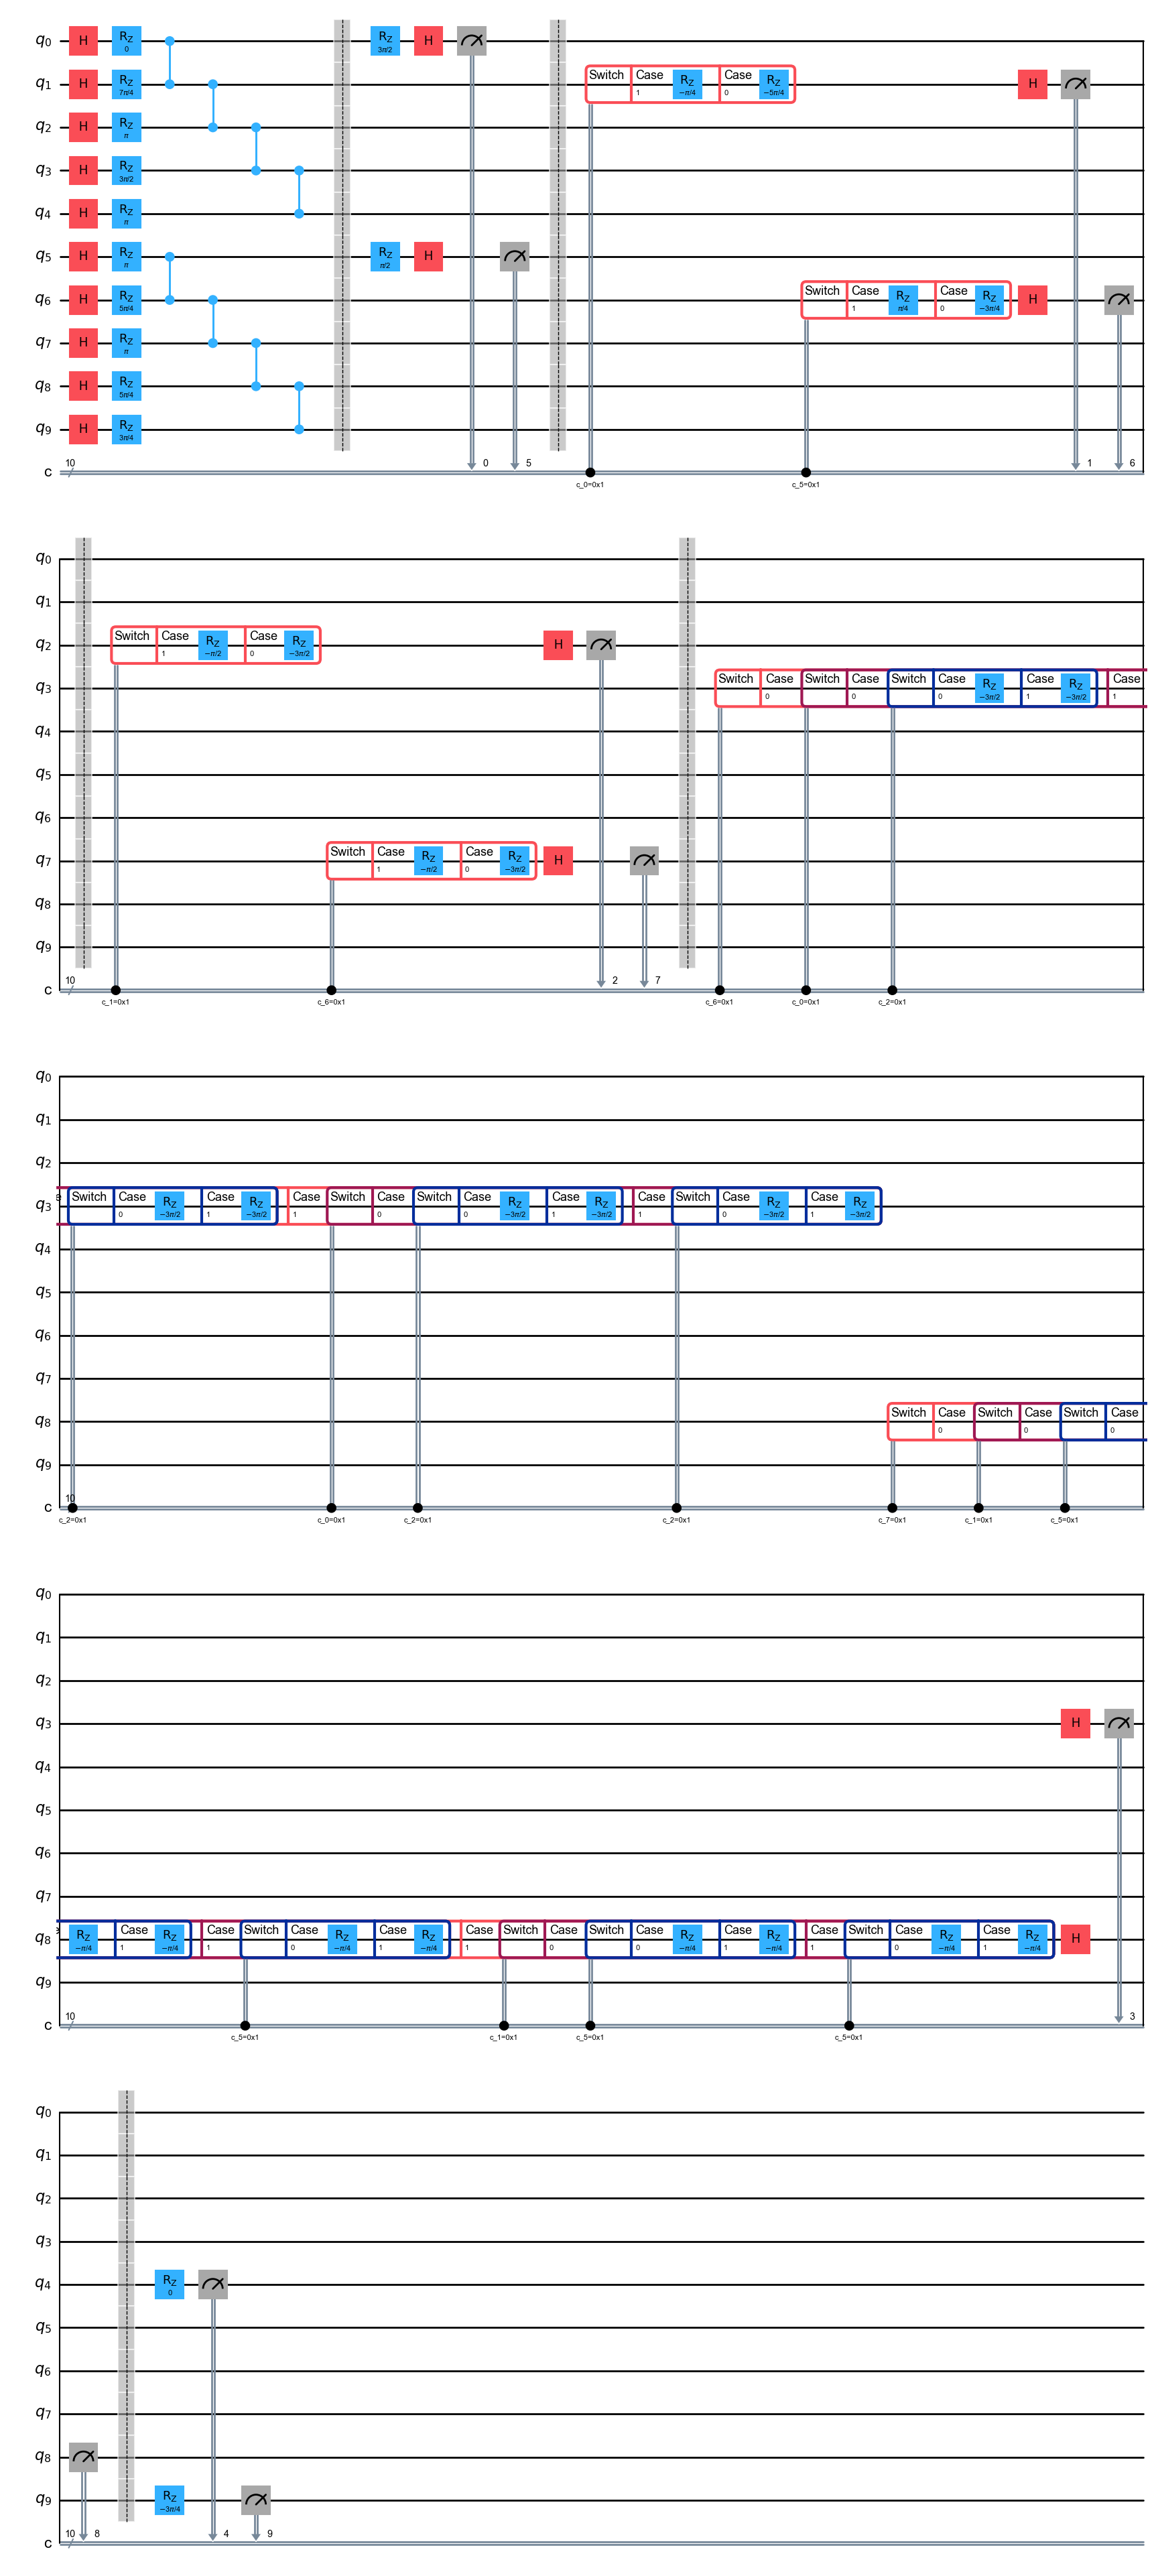

In [5]:
k_values = [secrets.randbelow(8) for _ in range(10)]
r_values = [secrets.randbelow(2) for _ in range(10)]
# Create the brickwork state circuit
brickwork_circuit = BrickworkStateCircuit(k_values, r_values)
brickwork_circuit.draw_circuit()

In [57]:
from qiskit.visualization import plot_histogram
# single shot simulation
simulator = AerSimulator()
circ = transpile(brickwork_circuit.qc, simulator)
# Run and get counts
results = simulator.run(brickwork_circuit.qc, shots=1).result()
# result = simulator.run(circ,10).result()
counts = results.get_counts(circ)
print("Before reserving control qubits:")
print(counts)
# Reserve the keys in the counts dictionary
for key in list(counts.keys()):
    new_key = key[::-1]  # Reverse the key
    counts[new_key] = counts.pop(key)  # Replace the key in the dictionary
print("After reserving control qubits:")
print(counts)
# Extract the counts
qubit_counts = [{"0": 0, "1": 0} for _ in range(10)]  # Initialize counts for 10 qubits

for key, value in counts.items():
    for i in range(10):
        qubit_counts[i][key[i]] += value  # Update counts for each qubit

# Pre-processing
print("Pre-processing")


# Print the results
for i in range(10):
    print(f"Counts for qubit {i}:")
    print(qubit_counts[i])

Before reserving control qubits:
{'1100011100': 1}
After reserving control qubits:
{'0011100011': 1}
Pre-processing
Counts for qubit 0:
{'0': 1, '1': 0}
Counts for qubit 1:
{'0': 1, '1': 0}
Counts for qubit 2:
{'0': 0, '1': 1}
Counts for qubit 3:
{'0': 0, '1': 1}
Counts for qubit 4:
{'0': 0, '1': 1}
Counts for qubit 5:
{'0': 1, '1': 0}
Counts for qubit 6:
{'0': 1, '1': 0}
Counts for qubit 7:
{'0': 1, '1': 0}
Counts for qubit 8:
{'0': 0, '1': 1}
Counts for qubit 9:
{'0': 0, '1': 1}


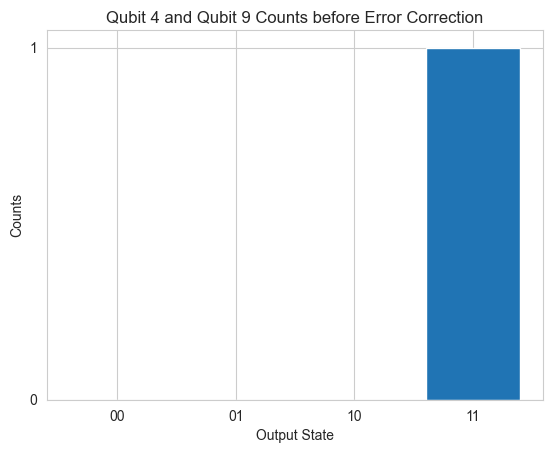

In [61]:
# Aggregate counts for |qubit4qubit9⟩ states
qubit_4_9_counts = {"00": 0, "01": 0, "10": 0, "11": 0}
for k, v in counts.items():
    state = f"{k[4]}{k[9]}"  # Extract qubit 4 (6th bit) and qubit 9 (1st bit) in correct order
    qubit_4_9_counts[state] += v

# Plot the aggregated counts
plt.bar(qubit_4_9_counts.keys(), qubit_4_9_counts.values(), color=(32/255, 116/255, 180/255))
plt.xlabel("Output State")
plt.ylabel("Counts")
plt.yticks([0, 1])  # Set y-ticks to only 0 and 1
plt.title("Qubit 4 and Qubit 9 Counts before Error Correction")
plt.show()

In [59]:
# Extract the bitstring result from counts (since it's a single shot)
bitstring = list(counts.keys())[0]  # We take the first (and only) key for the bitstring

# Convert the bitstring into a list for easy manipulation
qubit_states = list(bitstring)  # This gives us a list of '0's and '1's representing the state of each qubit
# Define a function to flip a qubit's state
def flip_qubit(state, index):
    state[index] = '1' if state[index] == '0' else '0'

# Flip qubits based on XOR logic (control qubits c1, c3, c6, c8)
if (int(qubit_states[1]) ^ int(qubit_states[3]) ^r_values[1] ^ r_values[3]) == 1:  # c1 ^ c3
    flip_qubit(qubit_states, 4)  # Flip q4 if c1 ^ c3  == 1

if (int(qubit_states[6]) ^ int(qubit_states[8])^r_values[6] ^ r_values[8]) == 1:  # c6 ^ c8
    flip_qubit(qubit_states, 9)  # Flip q9 if c6 ^ c8  == 1

# Now, qubit_states will reflect the corrected state
print("Corrected qubit states after flipping based on control qubits:")
print(qubit_states)

# You can also convert the final state back into a string for further analysis or visualization
corrected_bitstring = ''.join(qubit_states)
print(f"Corrected bitstring: {corrected_bitstring}")

Corrected qubit states after flipping based on control qubits:
['0', '0', '1', '1', '0', '0', '0', '0', '1', '0']
Corrected bitstring: 0011000010


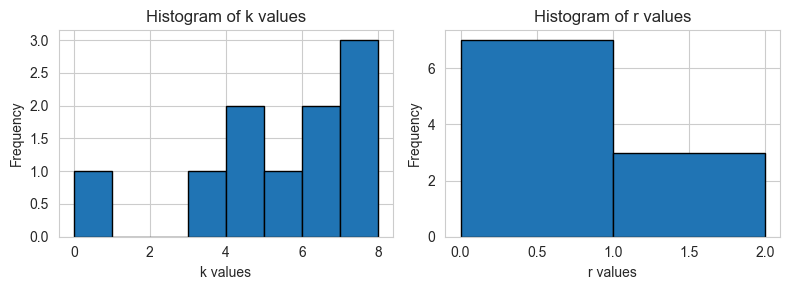

In [65]:
# plot k values and r values

# Plot histogram for k values
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.hist(k_values, bins=range(9), color=(32/255, 116/255, 180/255), edgecolor='black')
plt.xlabel('k values')
plt.ylabel('Frequency')
plt.title('Histogram of k values')

# Plot histogram for r values
plt.subplot(1, 2, 2)
plt.hist(r_values, bins=range(3), color=(32/255, 116/255, 180/255), edgecolor='black')
plt.xlabel('r values')
plt.ylabel('Frequency')
plt.title('Histogram of r values')

plt.tight_layout()
plt.show()


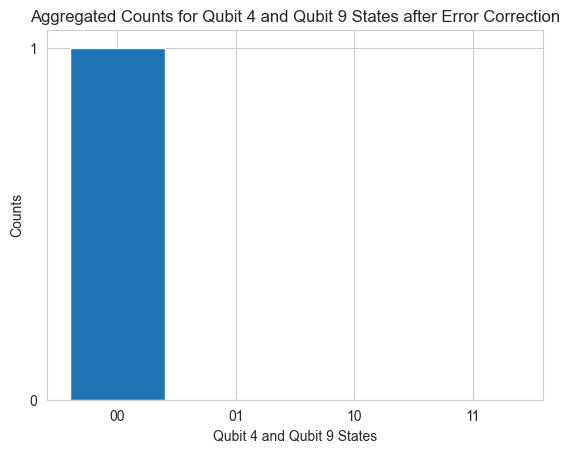

In [62]:
# Aggregate counts for qubit 4 and qubit 9 based on the new corrected state
qubit_4_9_counts = {"00": 0, "01": 0, "10": 0, "11": 0}

for k, v in counts.items():
    # Apply flips to the bitstring based on corrected state
    corrected_state = corrected_bitstring

    # Extract qubit 4 (index 4) and qubit 9 (index 9) from the corrected bitstring
    state = f"{corrected_state[4]}{corrected_state[9]}"  # Corrected qubits

    # Update the counts for the state of qubits 4 and 9
    qubit_4_9_counts[state] += v

# Plot the aggregated counts for the states of qubit 4 and qubit 9
plt.bar(qubit_4_9_counts.keys(), qubit_4_9_counts.values(), color=(32/255, 116/255, 180/255))
plt.xlabel("Qubit 4 and Qubit 9 States")
plt.ylabel("Counts")
plt.yticks([0, 1])  # Set y-ticks to only 0 and 1
plt.title("Aggregated Counts for Qubit 4 and Qubit 9 States after Error Correction")
plt.show()


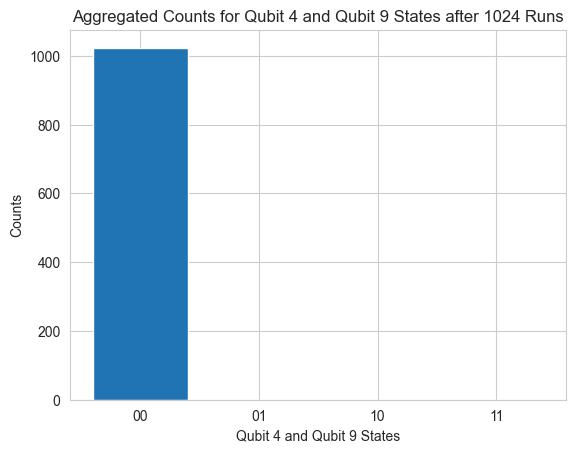

In [44]:
# num_runs times simulation of universal blind quantum computation
# Initialize the simulator
simulator = AerSimulator()

# Initialize a dictionary to store the counts for qubit 4 and qubit 9 states
qubit_4_9_counts = {"00": 0, "01": 0, "10": 0, "11": 0}

# Lists to store all k and r values from all runs
all_k_values = []
all_r_values = []

# Number of simulation runs
num_runs = 1024  # You can adjust this to the number of shots you want

# Run the simulation repeatedly and process the results
for _ in range(num_runs):
    # Generate new k and r values for each run
    k_values = [secrets.randbelow(8) for _ in range(10)]
    r_values = [secrets.randbelow(2) for _ in range(10)]

    # Store the k and r values
    all_k_values.extend(k_values)
    all_r_values.extend(r_values)

    # Create the brickwork state circuit
    brickwork_circuit = BrickworkStateCircuit(k_values, r_values)

    # Transpile the quantum circuit for the simulator
    circ = transpile(brickwork_circuit.qc, simulator)

    # Run the circuit with one shot
    results = simulator.run(circ, shots=1).result()
    counts = results.get_counts(circ)

    # Reverse the keys (reverse the bit strings to match the qubits order)
    for key in list(counts.keys()):
        new_key = key[::-1]  # Reverse the key
        counts[new_key] = counts.pop(key)

    # Process the results: extract the state of each qubit
    for key, value in counts.items():
        qubit_states = list(key)  # List of '0' and '1' representing qubit states

        # Flip qubits based on XOR logic (control qubits c1, c3, c6, c8)
        if (int(qubit_states[1]) ^ int(qubit_states[3]) ^ r_values[1] ^ r_values[3]) == 1:  # c1 ^ c3
            flip_qubit(qubit_states, 4)  # Flip q4 if c1 ^ c3 == 1

        if (int(qubit_states[6]) ^ int(qubit_states[8]) ^ r_values[6] ^ r_values[8]) == 1:  # c6 ^ c8
            flip_qubit(qubit_states, 9)  # Flip q9 if c6 ^ c8 == 1

        # Aggregate counts for qubit 4 and qubit 9
        state = f"{qubit_states[4]}{qubit_states[9]}"  # Extract the flipped states of q4 and q9
        qubit_4_9_counts[state] += value  # Update the counts


# Plot the aggregated counts for qubit 4 and qubit 9 states
plt.bar(qubit_4_9_counts.keys(), qubit_4_9_counts.values(), color=(32/255, 116/255, 180/255))
plt.xlabel("Qubit 4 and Qubit 9 States")
plt.ylabel("Counts")
plt.title(f"Aggregated Counts for Qubit 4 and Qubit 9 States after {num_runs} Runs")
plt.show()

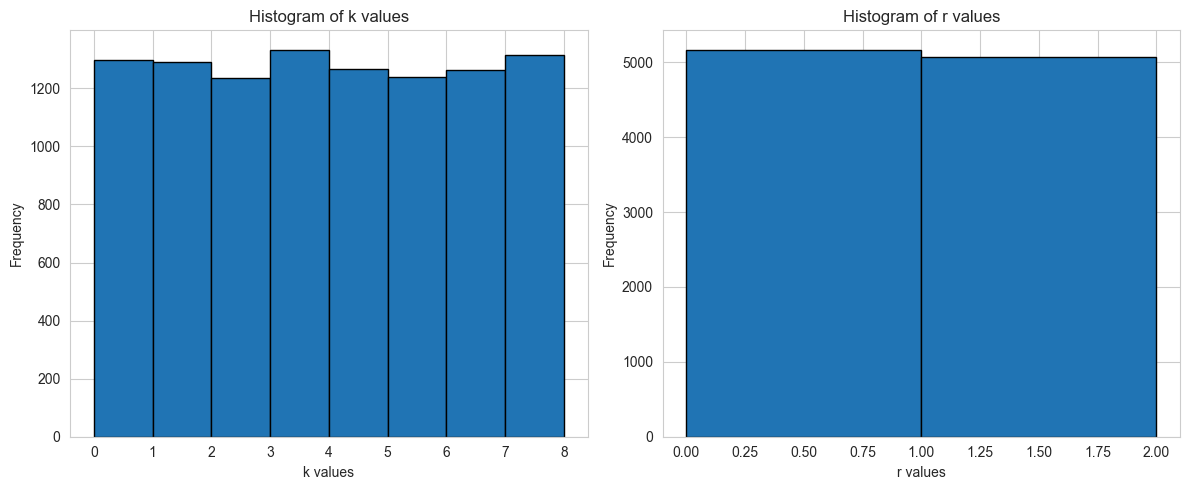

In [45]:
# Plot histogram for k values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(all_k_values, bins=range(9), color=(32/255, 116/255, 180/255), edgecolor='black')
plt.xlabel('k values')
plt.ylabel('Frequency')
plt.title('Histogram of k values')

# Plot histogram for r values
plt.subplot(1, 2, 2)
plt.hist(all_r_values, bins=range(3), color=(32/255, 116/255, 180/255), edgecolor='black')
plt.xlabel('r values')
plt.ylabel('Frequency')
plt.title('Histogram of r values')

plt.tight_layout()
plt.show()